In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [101]:
def gauss(x, mean = 0.0, var = 0.0001, amp = 1.0):
    return amp * np.exp(- (x - mean) ** 2 / (2 * var))



def signal_gauss(x, alpha0 = [0.01, -0.01], scale = 0.00001, amp = [1.0, 1.0]):
    result = 0
    for idx, pos in enumerate(alpha0):
        result += gauss(x, pos, scale, amp[idx])
    return result



def Fexp(alpha, n = 0, k = 2 * np.pi, d = 0.7, sign = 1):
    return np.exp(sign * 1j * alpha * n * k * d)



def Cn_deltaf_compute(n, k, d, alpha0 = [0.01, -0.01]):
    result = 0
    for target in alpha0:
        result += Fexp(target, n, k, d)
    return result



def U_compute(alpha, Cn, k, d):
    result = 0
    M = len(Cn)
    delta = (M - 1) // 2
    for n, C in enumerate(Cn):
        result += C * Fexp(alpha, n - delta, k, d, -1)
    return result

In [127]:
K = 25              # Реальное количество излучателей
NP = 400            # Виртуальное количество излучателей
k = 2 * np.pi       # Волновое число
d = 0.7             # Расстояние между излучателями

alpha = np.linspace(-0.02, 0.02, 2000)  # Угловое разрешение области
targets = [0.0010, -0.004]              # Положения целей
amplitude = [100, 200]                  # Интенсивности целей для отрисовки, на вычисления не влияют

In [128]:
n_real = np.arange(-K, K + 1)                 # Реальное перечисление номеров излучателей
n_virtual = np.arange(-NP, NP + 1)            # Идеальное (виртуальное) число излучателей

Cn_real = Cn_deltaf_compute(n_real, k, d, targets)              # Реальные Cn излучателей от -K до K включительно
Cn_virtual = Cn_deltaf_compute(n_virtual, k, d, targets)        # Виртуальные Cn излучателей (как хотим чтобы было)

# Для отрисовки целей
signals = signal_gauss(alpha, alpha0 = targets, scale = 0.00000005, amp = amplitude)  

# Реально принятый сигнал
U_real = U_compute(alpha, Cn_real, k, d)

# Как должно быть по факту
U_virtual = U_compute(alpha, Cn_virtual, k, d)

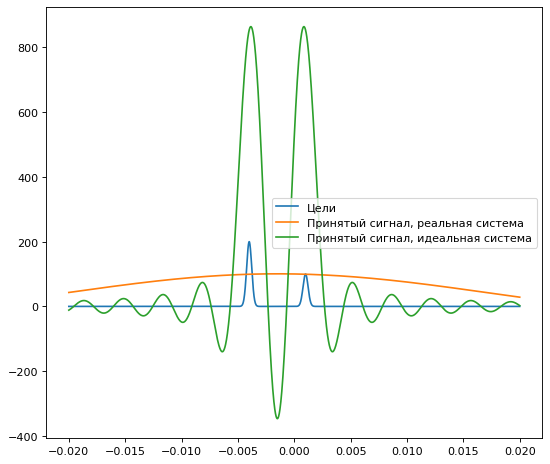

In [129]:
plt.figure(figsize = (8, 7), dpi = 80)
plt.plot(alpha, signals, label = "Цели")
plt.plot(alpha, U_real, label = "Принятый сигнал, реальная система")
plt.plot(alpha, U_virtual, label = "Принятый сигнал, идеальная система")
plt.legend()

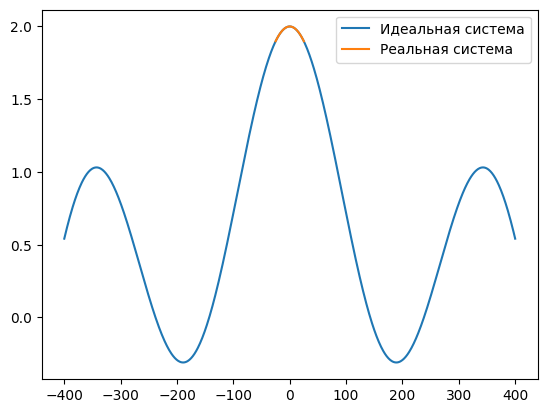

In [130]:
plt.plot(n_virtual, Cn_virtual, label = "Идеальная система")
plt.plot(n_real, Cn_real, label = "Реальная система")
plt.legend()